# Skin Cancer Prediction using CNN
**Problem Statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Importing Libraries

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization
from skimage import io
import random
import pathlib

# Mount from Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Path for Train and Test Dataset

In [3]:
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Test')

# Size of Train and Test 

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Specifying the Image Dimention 

In [5]:
batch_size = 32
img_height = 180
img_width = 180

# Train and Validation Generation in 80:20 Ratio

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               validation_split=0.2,
                                                               subset = 'training',seed=123,batch_size=batch_size,
                                                               image_size = (img_height, img_width))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
print(train_ds)

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             validation_split=0.2,
                                                             subset='validation',seed=123,batch_size=batch_size,
                                                             image_size = (img_height, img_width))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
print(val_ds)

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


# Checking Total Number of Classes

In [10]:
# Printing class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
num_classes = len(class_names)
print('Total no of classes: {}'.format(num_classes))

Total no of classes: 9


# Number of Images Availabe in each Classes

In [12]:
available_images = []
for cancer in class_names:
  path_str = os.path.join(data_dir_train, cancer)
  cancer_dir = pathlib.Path(path_str)
  content = len(list(cancer_dir.glob("*.jpg")))
  available_images.append(content)
df = pd.DataFrame({'Cancer Type':class_names,
                   'Available Images':available_images})
df_sorted = df.sort_values(by='Available Images', ascending=False)
df_sorted

,Cancer Type,Available Images
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


# Bar Plot of Value Count of Each Classes

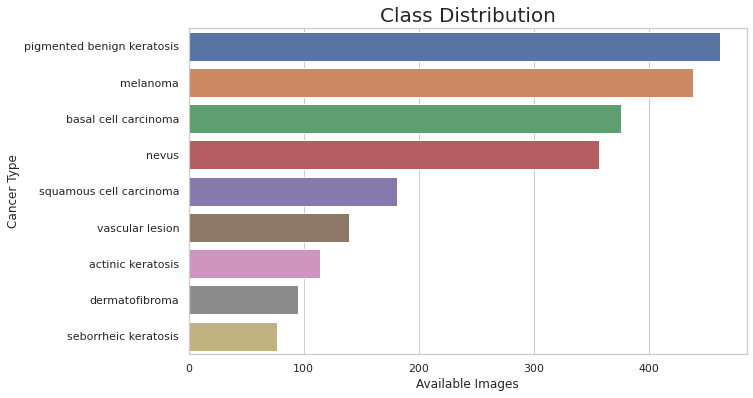

In [14]:
import seaborn as sns
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y="Cancer Type", x="Available Images", data=df_sorted)
plt.title("Class Distribution", {'fontsize':20})
plt.show()

### Inferences:
- **Pigmented benign keratosis** has the highest no of samples(462) among all other cancer types and thus it dominates other cancer types
- **Seborrheic keratosis** has the least no of samples(77)  

# Visualizing the dataset


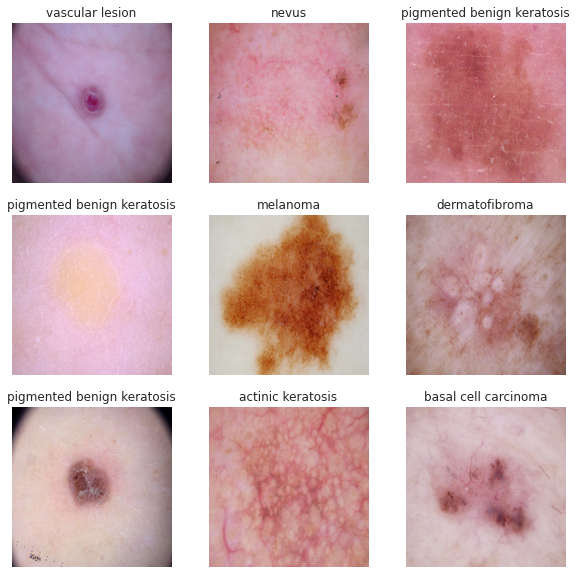

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(num_classes):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Batch Shape Checking

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


Above code results that, each batch is of size 32 as specified earlier and also size of each image in the batch is set to 180*180 with RGB channels

In [17]:
print(labels_batch)

tf.Tensor([5 1 8 4 5 1 4 5 3 5 5 8 3 3 8 5 1 6 5 8 3 3 1 1 4 1 2 4 4 1 4 1], shape=(32,), dtype=int32)


We can see from above batch labels that we have class labels represented in the form of Sparse matrix form (and not one-hot encoded format)\
So while compiling the model, we have to use the loss function as `tf.keras.losses.SparseCategoricalCrossEntropy` instead of `tf.keras.losses.CategoricalCrossEntropy`

### Configuring the dataset for performance
`tf.data` API provides `tf.data.Dataset.prefetch` transformation. Prefetching overlaps preprocessing and model execution in the training step. Thus reduces the time for training.

The no of elements to prefetch should be equal to (or greater than) the no of batches consumed by single training step.  `tf.data.AUTOTUNE` tunes this value dynamically during runtime

# Tuning the Dataset using Autotune

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# CNN Model with 3 Convolutional Layers


In [19]:
model1 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Scaling pixel values between [0,1]
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

# Compiling with ADAM optimizer and SparceCategoricalCrossentropy Loss

In [20]:
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

# Summary of 1st CNN Model

In [21]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

# Model Training

In [22]:
epochs = 20
history = model1.fit(train_ds,
                  validation_data=val_ds,
                  epochs=epochs)

Epoch 1/20
56/56 [==============================] - 315s 1s/step - loss: 2.1103 - accuracy: 0.2121 - val_loss: 1.9791 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.8384 - accuracy: 0.3398 - val_loss: 1.7525 - val_accuracy: 0.4362
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5927 - accuracy: 0.4498 - val_loss: 1.6868 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4331 - accuracy: 0.5000 - val_loss: 1.4659 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3238 - accuracy: 0.5357 - val_loss: 1.4048 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2610 - accuracy: 0.5681 - val_loss: 1.5680 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1752 - accuracy: 0.5982 - val_loss: 1.3434 - val_accuracy: 0.5593
Epoch 8/20
56

# Analysing Result using Loss and Accuracy Plots

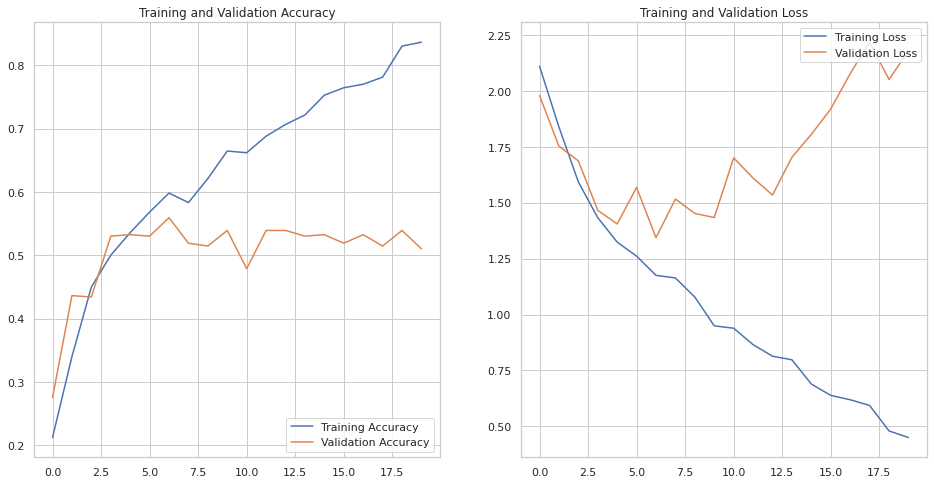

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# We can see there is Overfitting 

### Inferences:
- The training accuracy is increasing as epochs are increasing, but the validation accuracy is flattening out around 50%
- As epochs are increasing the gap between training and validation accuracy is increasing- this is the sign of overfit
- In order to reduce the overfit, we implement data augmentation techniques

## Data Augmentation
We will include data augmentation layer in the model at start. We will use `RandomFlip`, `RandomRotation` and `RandomZoom` methods to do augmentation and generalize the training dataset 

In [24]:
augmentation_layer = keras.Sequential([
                                       layers.experimental.preprocessing.RandomFlip(mode='horizontal',input_shape=(img_height,img_width,3)),
                                       layers.experimental.preprocessing.RandomRotation(0.3)])

# Augmented Data

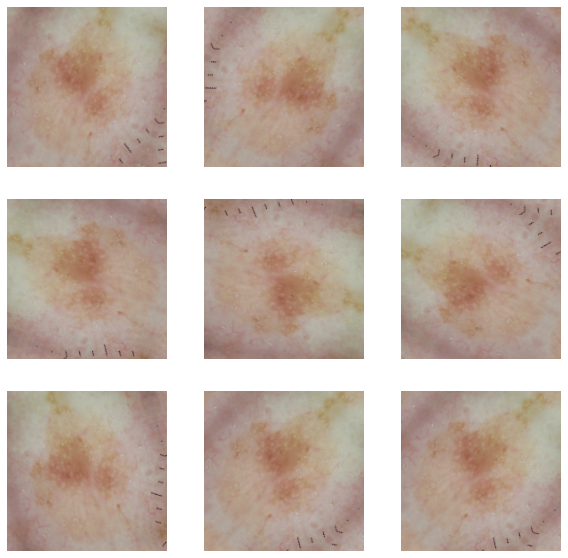

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# CNN Model with 3 Convolutional Layers

In [32]:
model2 = Sequential([
                    augmentation_layer,
                    layers.experimental.preprocessing.Rescaling(1./255),
                    Conv2D(16, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Conv2D(64, 3, padding='same', activation = 'relu'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(num_classes)
])

# Compiling with ADAM optimizer and SparceCategoricalCrossentropy Loss

In [33]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summary of 2nd CNN Model

In [34]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [35]:
epochs = 20
history = model2.fit(train_ds,
                    validation_data = val_ds,
                    epochs=epochs)

Epoch 1/20
56/56 [==============================] - 2s 24ms/step - loss: 2.2137 - accuracy: 0.2098 - val_loss: 1.9318 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7712 - accuracy: 0.3650 - val_loss: 1.6896 - val_accuracy: 0.4161
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5454 - accuracy: 0.4425 - val_loss: 1.4541 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4586 - accuracy: 0.4866 - val_loss: 1.5181 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4150 - accuracy: 0.5061 - val_loss: 1.4140 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3363 - accuracy: 0.5268 - val_loss: 1.3295 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3130 - accuracy: 0.5324 - val_loss: 1.3471 - val_accuracy: 0.5369
Epoch 8/20
56

# Analysing Result using Loss and Accuracy Plots

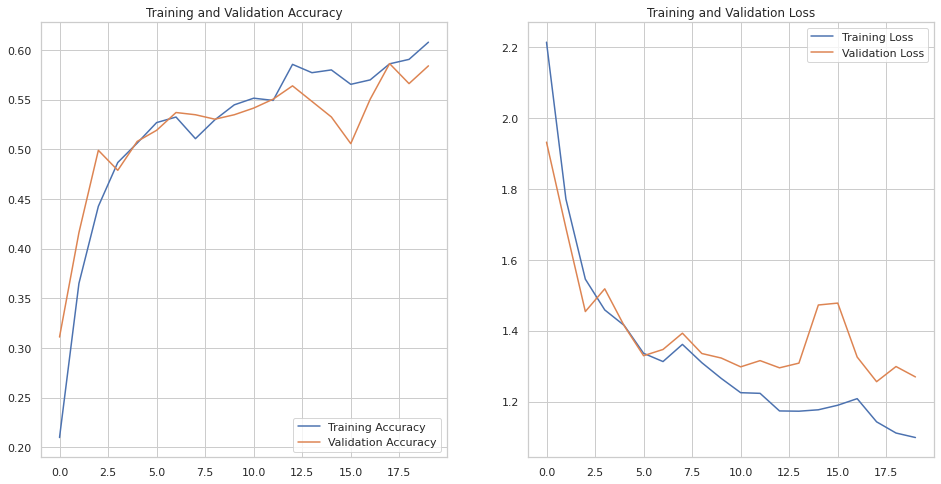

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# The Overfitting Issue Solved

### Inferences:
- Here we can see that the overfitting has been reduced as we have used data augmentation techniques

# Installing Augmentor Library

In [37]:
!pip install Augmentor

In [38]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

# Handling Data Imbalance issues for each classes using Augmentor Library

## Making 250 images in total for each classes

In [39]:
path_to_training_dataset='/content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.6, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.4)
    p.sample(250) ## We are adding 250 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/250 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4466105A50>: 100%|██████████| 250/250 [00:08<00:00, 27.94 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F446617D4D0>:   0%|          | 1/250 [00:00<00:29,  8.55 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4466048E10>: 100%|██████████| 250/250 [00:08<00:00, 30.16 Samples/s]
Executing Pipeline:   0%|          | 0/250 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F44660BC590>: 100%|██████████| 250/250 [00:09<00:00, 27.01 Samples/s]
Executing Pipeline:   0%|          | 0/250 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F44660D4F10>: 100%|██████████| 250/250 [00:35<00:00,  7.07 Samples/s]
Executing Pipeline:   0%|          | 0/250 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F4466053C50>: 100%|██████████| 250/250 [00:34<00:00,  7.28 Samples/s]
Executing Pipeline:   0%|          | 0/250 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F44180FA3D0>: 100%|██████████| 250/250 [00:09<00:00, 26.69 Samples/s]
Executing Pipeline:   0%|          | 0/250 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F446608F450>: 100%|██████████| 250/250 [00:19<00:00, 13.07 Samples/s]
Executing Pipeline:   0%|          | 0/250 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4466114ED0>: 100%|██████████| 250/250 [00:09<00:00, 27.76 Samples/s]
Executing Pipeline:   0%|          | 0/250 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/upGrad Notebooks/Skin_Cancer_Prediction/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F448A200350>: 100%|██████████| 250/250 [00:08<00:00, 27.86 Samples/s]


In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

2250


# Total of 2250 augmented images of all 9 classes

In [41]:
# Path list of all the Augmented Images in /output folder in each class folder
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [42]:
# Label corresponding to each path in path list 
label_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

# Making a DataFrame 

In [43]:
df_path_label = pd.DataFrame()
df_path_label['Path'] = path_list
df_path_label['Label'] = label_list_new

In [44]:
df_path_label.head()

,Path,Label
0,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma
1,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma
2,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma
3,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma
4,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma


# Saving the Dataset for Emergency Cases

In [ ]:
df_path_label.to_csv("path_label.csv")

In [ ]:
df_path_label = pd.read_csv("path_label.csv")

# Equal Number of Images for Each Class

In [45]:
df_path_label['Label'].value_counts()

seborrheic keratosis          250
pigmented benign keratosis    250
dermatofibroma                250
basal cell carcinoma          250
nevus                         250
melanoma                      250
vascular lesion               250
squamous cell carcinoma       250
actinic keratosis             250
Name: Label, dtype: int64

## Making dataframe of Path:Label from the original dataset of images we had earlier 

In [46]:
path_list_original = [x for x in list(data_dir_train.glob('*/*.jpg'))]
label_list_original = [os.path.basename(os.path.dirname(y)) for y in list(data_dir_train.glob('*/*.jpg'))]

df_path_label_original = pd.DataFrame()
df_path_label_original['Path'] = path_list_original
df_path_label_original['Label'] = label_list_original

df_path_label_original.head()

,Path,Label
0,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma
1,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma
2,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma
3,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma
4,/content/gdrive/MyDrive/upGrad Notebooks/Skin_...,squamous cell carcinoma


# Original Class distribution

In [47]:
df_path_label_original['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### Adding two dataframes to create a single dataframe containing original and Augmented images for our analysis

In [48]:
df_path_label_all = pd.concat([df_path_label, df_path_label_original])
df_path_label_all['Path'] = df_path_label_all['Path'].astype('str')
df_path_label_all['Label'].value_counts()

pigmented benign keratosis    712
melanoma                      688
basal cell carcinoma          626
nevus                         607
squamous cell carcinoma       431
vascular lesion               389
actinic keratosis             364
dermatofibroma                345
seborrheic keratosis          327
Name: Label, dtype: int64

# Calling ImageDataGenerator 

In [49]:
from keras_preprocessing.image import ImageDataGenerator

In [50]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(dataframe = df_path_label_all, directory = None,
                                              x_col = 'Path', y_col = 'Label',target_size = (img_height, img_width),
                                              class_mode='sparse', batch_size = 32, subset = 'training')

val_generator = datagen.flow_from_dataframe(dataframe = df_path_label_all, directory = None,
                                              x_col = 'Path', y_col = 'Label',target_size = (img_height, img_width),
                                              class_mode='sparse', batch_size = 32, subset = 'validation')

Found 3592 validated image filenames belonging to 9 classes.
Found 897 validated image filenames belonging to 9 classes.


In [51]:
train_generator

# We will use `callbacks` function on Keras library to reduce the learning rate when validation loss is becoming stagnant

In [52]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.001)

- We are monitoring `val_loss` parameter
- When LR becoming stagnant, we reduce it by `factor` specified. i.e new LR = old LR * `factor`
- `patience` = 2 implies we would wait for 2 epochs to update the LR
- Minimum LR can be equal to 0.001

# CNN Model with 2 convolutional layers

In [53]:
model3 = tf.keras.models.Sequential([                                   
                    Conv2D(16, 3, padding='same', activation='relu'),                    
                    MaxPooling2D(),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(),                    
                    Dropout(0.25),
                    Flatten(),
                    Dense(64, activation='relu'),
                    Dense(num_classes)
])

# Compiling with ADAM optimizer and SparceCategoricalCrossentropy Loss

In [54]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
epochs = 40
history = model3.fit(train_generator,
                    validation_data = val_generator,
                    epochs=epochs, callbacks=[reduce_lr])

Epoch 1/40
113/113 [==============================] - 56s 496ms/step - loss: 1.8351 - accuracy: 0.4112 - val_loss: 2.1113 - val_accuracy: 0.0981
Epoch 2/40
113/113 [==============================] - 56s 492ms/step - loss: 1.3287 - accuracy: 0.5276 - val_loss: 2.0618 - val_accuracy: 0.1360
Epoch 3/40
113/113 [==============================] - 54s 478ms/step - loss: 1.1118 - accuracy: 0.5958 - val_loss: 1.7789 - val_accuracy: 0.2687
Epoch 4/40
113/113 [==============================] - 55s 490ms/step - loss: 0.9676 - accuracy: 0.6470 - val_loss: 3.8069 - val_accuracy: 0.0702
Epoch 5/40
113/113 [==============================] - 55s 482ms/step - loss: 0.8119 - accuracy: 0.7091 - val_loss: 1.6236 - val_accuracy: 0.4270
Epoch 6/40
113/113 [==============================] - 55s 483ms/step - loss: 0.6127 - accuracy: 0.7792 - val_loss: 3.2445 - val_accuracy: 0.2196
Epoch 7/40
113/113 [==============================] - 54s 477ms/step - loss: 0.4852 - accuracy: 0.8360 - val_loss: 2.9072 - val_ac

# Analysing Result using Loss and Accuracy Plots

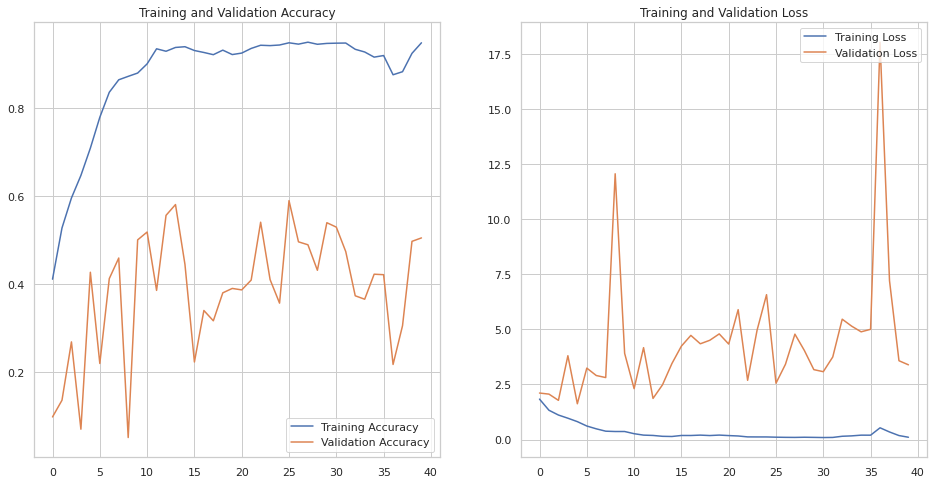

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## `Augmentor` library doesn't seem to provide good model fit, instead it is resulting in overfit
### The highest accuracy I am getting id 60%
##### To furthur increase the validation accuracy or reduce the overfit, we should use Transfer Learning by using pre-trained models like ResNet, GoogleNet or VGGNet